In [22]:
import experiments_func as exp
import matplotlib.pyplot as plt
import block_division_func as bd
import networkx as nx
import random
import math
import time
import csv
import matplotlib.ticker as ptick

In [23]:
def compute_communication_cost(state, converter, num_blocks, linked_blocks, G):
    total_cost = 0
    for i in range(num_blocks):
        for j in linked_blocks[i]:
            if i >= num_blocks or j >= num_blocks:
                print(i, j)
            cost = nx.dijkstra_path_length(G, str(converter[state[i]]), str(converter[state[j]]))
            total_cost += cost
    return total_cost

# Function to generate a neighboring state
def generate_neighbor(state, num_blocks):
    neighbor = state.copy()
    task1, task2 = random.sample(range(num_blocks), 2)
    neighbor[task1], neighbor[task2] = neighbor[task2], neighbor[task1]
    return neighbor

# Function to calculate the acceptance probability
def acceptance_probability(delta_cost, temperature):
    if delta_cost < 0:
        return 1.0
    return math.exp(-delta_cost / temperature)

# Simulated annealing algorithm
def simulated_annealing(initial_state, converter, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate):
    current_state = initial_state.copy()
    best_state = current_state.copy()
    current_cost = compute_communication_cost(current_state, converter, num_blocks, linked_blocks, G)
    best_cost = current_cost
    temperature = initial_temperature

    for iteration in range(max_iterations):
        neighbor = generate_neighbor(current_state, num_blocks)
        neighbor_cost = compute_communication_cost(neighbor, converter, num_blocks, linked_blocks, G)
        delta_cost = neighbor_cost - current_cost

        if acceptance_probability(delta_cost, temperature) > random.random():
            current_state = neighbor
            current_cost = neighbor_cost

        if current_cost < best_cost:
            best_state = current_state.copy()
            best_cost = current_cost

        temperature *= cooling_rate

        # if iteration % 1000 == 0:
        #     converted_state = exp.convert_node_number(converter, current_state)
            # print(f'iteration: {iteration+1000}')
            # print(f'current_state: {converted_state}')
            # print(f'current_cost: {current_cost}\n')
    return best_state, best_cost

In [24]:
# print("start")
# experiment = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
# experiment = [5000]
experiment = [50000, 45000, 40000, 35000, 30000, 25000, 20000, 15000, 10000, 5000]


sa_result = []
comm_cost_result = []
slots_result = []
comm_cost_and_slots_result = []


# 実験環境
# GraphML形式のグラフを読み込む
G = nx.read_edgelist("/home/yamamoto/research/consideration_of_computer_power/src/data/japanese_network.edgelist", data=False)

# ノード番号を文字列から数字に変換する
# mapping = {node: i for i, node in enumerate(G.nodes())}
# G = nx.relabel_nodes(G, mapping)

pos = nx.spring_layout(G)
# nx.draw_networkx(G, pos)

# 焼きなまし法(simulated annealing)のパラメータ
max_iterations = 500
initial_temperature = 100.0
cooling_rate = 0.95

# 分散処理に使用するPCの数
num_pcs = 50
# 分割するブロックの数
num_blocks_total = 65000

# ニューラルネットワークの分割ブロックの構造を表す
# structure_row = 2 # ブロックの行数
# structure_col = num_blocks_total // structure_row # ブロックの列数

# トポロジにある計算機の数
num_nodes = G.number_of_nodes()
# トポロジにある計算機にキャパシティを割り当てる
capacities = exp.generate_random_numbers(num_nodes, num_blocks_total)

# ランダムにノードを {num_pcs}個取得
random_nodes = exp.get_random_nodes(graph=G, num_pcs=num_pcs)
# ランダムノードのキャパシティ
random_capacities = [capacities[node] for node in random_nodes]
# exchange_matrix_random = exp.generate_exchange_matrix(random_nodes, num_pcs, G)

# 計算機群からキャパシティ上位{num_pcs}個の計算機を取得
# top_indices = exp.get_top_n_indices(capacities, num_pcs)
# 上位ノードのキャパシティ
# top_capacities = [capacities[node] for node in top_indices]
# 上位ノードの交流行列を作成
# exchange_matrix = exp.generate_exchange_matrix(top_indices, num_pcs, G)

# ニューラルネットワークを分割したブロック
# block_structure = bd.generate_block_structure(row=structure_row, col=structure_col)

# 通信する必要のあるブロックのリストを作成(ブロックの接続関係)
# linked_blocks = bd.generate_linked_block_list(block_structure)

In [25]:
for i, blocks in enumerate(experiment):
    
    # ニューラルネットワークの分割ブロックの構造を表す
    structure_row = 2 # ブロックの行数
    structure_col = blocks // structure_row # ブロックの列数
    
    # ニューラルネットワークを分割したブロック
    block_structure = bd.generate_block_structure(row=structure_row, col=structure_col)
    
    # 通信する必要のあるブロックのリストを作成(ブロックの接続関係)
    linked_blocks = bd.generate_linked_block_list(block_structure)

    # 分割するブロックの数(実験で使用する)
    num_blocks = blocks
    
    # 分割ブロックの番号リスト
    block_list = bd.generate_block_list(num_blocks=num_blocks)

    # ランダムに割り当てる
    random_assigned_matrix = bd.generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities)
    # random_random_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_assigned_matrix, converter=random_nodes, G=G)
    
    # ランダムにノードを選択し、ランダムに割り当てて、焼きなまし法を使って組み合わせ最適化
    _, sa_total_cost = simulated_annealing(random_assigned_matrix, random_nodes, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate)

    # ランダムにノードを選択し、通信コストだけを見てグリーディーに割り当て
    random_exchange_matrix = exp.generate_exchange_matrix(random_nodes, num_pcs, G)
    commcost_greedy_assignment = exp.generate_comm_cost_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities, exchange_matrix=random_exchange_matrix)
    comm_cost_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=commcost_greedy_assignment, converter=random_nodes, G=G)

    # ランダムにノードを選択し、スロット数だけを見てグリーディーに割り当て
    slots_greedy_assignment = exp.generate_slots_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities, exchange_matrix=random_exchange_matrix)
    slots_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=slots_greedy_assignment, converter=random_nodes, G=G)
    
    # ランダムにノードを選択し、通信コストとスロット数を見てグリーディーに割り当て
    comm_cost_and_slots_greedy_assignment = exp.generate_commcost_and_slots_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities, exchange_matrix=random_exchange_matrix)
    comm_cost_and_slots_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=comm_cost_and_slots_greedy_assignment, converter=random_nodes, G=G)
    
    print(f'{i+1}回目, ブロック数: {blocks}')

    print(f'焼きなまし法を行った場合の総通信コスト: {sa_total_cost}')
    print(f'通信コストだけを見てグリーディー割り当て行った場合の総通信コスト: {comm_cost_total_cost}')
    print(f'スロット数だけを見てグリーディー割り当て場合の総通信コスト: {slots_total_cost}')
    print(f'通信コストとスロット数を見てグリーディー割り当て場合の総通信コスト: {comm_cost_and_slots_total_cost}')
    
    
    sa_result.append(sa_total_cost)
    comm_cost_result.append(comm_cost_total_cost)
    slots_result.append(slots_total_cost)
    comm_cost_and_slots_result.append(comm_cost_and_slots_total_cost)

1回目, ブロック数: 50000
焼きなまし法を行った場合の総通信コスト: 991472
通信コストだけを見てグリーディー割り当て行った場合の総通信コスト: 206
スロット数だけを見てグリーディー割り当て場合の総通信コスト: 196
通信コストとスロット数を見てグリーディー割り当て場合の総通信コスト: 240


KeyboardInterrupt: 

In [2]:
# Save the results to a CSV file
# results_file = '/home/yamamoto/research/consideration_of_computer_power/src/result/results.csv'
# with open(results_file, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Number of Blocks', 'sa', 'comm_cost_Greedy', 'slots_greedy', 'comm_cost_and_slots_greedy'])
#     for i in range(len(experiment)):
#         writer.writerow([experiment[i], sa_result[i], comm_cost_result[i],
#                          slots_result[i], comm_cost_and_slots_result[i]])
results_file = '/home/yamamoto/research/consideration_of_computer_power/src/result/results.csv'
with open(results_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Number of Blocks', 'sa', 'comm_cost_Greedy', 'slots_greedy', 'comm_cost_and_slots_greedy'])
    for i in range(len(experiment)):
        writer.writerow([experiment[(len(experiment)-1)-i], sa_result[(len(experiment)-1)-i], comm_cost_result[(len(experiment)-1)-i],
                         slots_result[(len(experiment)-1)-i], comm_cost_and_slots_result[(len(experiment)-1)-i]])

NameError: name 'csv' is not defined

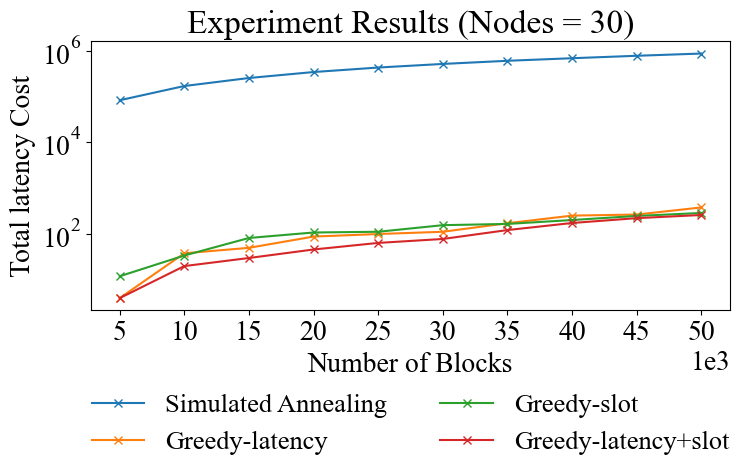

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import csv

results_file = '/home/yamamoto/research/consideration_of_computer_power/src/result/30PC_results.csv'

# Read the results from the CSV file
results = []
with open(results_file, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        results.append(row)

# Extract the data from the results
headers = results[0]
data = results[1:]
experiment = [int(row[0]) for row in data]
sa = [float(row[1]) for row in data]
comm_cost_Greedy = [float(row[2]) for row in data]
slots_greedy = [float(row[3]) for row in data]
comm_cost_and_slots_greedy = [float(row[4]) for row in data]

# 0があると対数グラフが上手く描画できないので0の時は1にする
epsilon = 1
sa = [val if val != 0 else epsilon for val in sa]
comm_cost_Greedy = [val if val != 0 else epsilon for val in comm_cost_Greedy]
slots_greedy = [val if val != 0 else epsilon for val in slots_greedy]
comm_cost_and_slots_greedy = [val if val != 0 else epsilon for val in comm_cost_and_slots_greedy]

plt.clf()
# Plot the graph
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (8,5.5) #(幅, 高さ)
plt.plot(experiment, sa, label='Simulated Annealing', marker='x')
plt.plot(experiment, comm_cost_Greedy, label='Greedy-latency', marker='x')
plt.plot(experiment, slots_greedy, label='Greedy-slot', marker='x')
plt.plot(experiment, comm_cost_and_slots_greedy, label='Greedy-latency+slot', marker='x')
plt.xlabel('Number of Blocks')
plt.ylabel('Total latency Cost')
plt.title('Experiment Results (Nodes = 30)')
plt.legend(loc='upper center', bbox_to_anchor=(.5, -.22), ncol=2, fontsize=19, frameon=False)
plt.xticks(range(5000, max(experiment) + 1, 5000))
plt.ticklabel_format(style="sci", axis="x", scilimits=(3,3))
plt.yscale('log')
plt.tight_layout()
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/30PC_graph1.png')
plt.show()

In [ ]:
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 18
# # グラフの設定
# # plt.plot(experiment, random_nodes_random_result, label='Random_nodes + Random')
# plt.plot(experiment, random_nodes_random_SA_result, label='Random_nodes + Simulated Annealing', marker='x')
# plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy', marker='x')
# # plt.plot(experiment, random_nodes_greedy_SA_result, label='Random_nodes + Greedy + Simulated Annealing')
# # plt.plot(experiment, top_nodes_random_result, label='top_nodes + Random')
# plt.plot(experiment, top_nodes_random_SA_result, label='top_nodes + Simulated Annealing', marker='x')
# plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy', marker='x')
# # plt.plot(experiment, top_nodes_greedy_SA_result, label='top_nodes + Greedy + Simulated Annealing')

# plt.xlabel('Number of Blocks')
# plt.ylabel('Total Communication Cost')
# plt.title('Experiment Results (Nodes = 30)')
# plt.legend()
# # x軸の目盛り設定
# plt.xticks(range(5000, max(experiment)+1, 5000))
# plt.yscale('log')  # y軸を対数スケールに変更
# plt.tight_layout()
# # グラフの保存
# plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/30PC_graph2.png')
# # グラフの表示
# plt.show()

In [ ]:
# plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy', marker='x')
# plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy', marker='x')

# plt.xlabel('Number of Blocks')
# plt.ylabel('Total Communication Cost')
# plt.title('Experiment Results')
# plt.legend()
# # x軸の目盛り設定
# plt.xticks(range(500, max(experiment)+1, 500))
# # グラフの保存
# plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph2.png')
# # グラフの表示
# plt.show()
